Parse Text Data, make Train Split
---

In [41]:
import glob
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, vstack
import numpy as np
from sklearn.preprocessing import normalize

def parse_lyrics():
    parsed = {"unique_line_ratios": [], "unique_word_ratios_song": [], "artists": [],
             "titles": [], "genres": [], "raw_lyrics": [], "total_word_counts": [], 
              "average_character_count_word":[], "average-words-per-line":[]}
    
    #iterate through files
    for filename in glob.iglob('data/*.txt'):
        genre = filename[5:len(filename)-4]
        numberOfSongs = 0
        file = open(filename)
        lines = file.readlines()
        i = 0
        while i < len(lines) and not lines[i].startswith("###"):
            i = i + 1
        while i < len(lines):
            numberOfSongs = numberOfSongs + 1
            parsed["artists"].append(lines[i][3:].strip())
            parsed["titles"].append(lines[i+1][3:].strip())
            parsed["genres"].append(genre) 
            i = i + 2
            #extract features from song
            
            lyrics = []
            while i < len(lines) and not lines[i].startswith("###"):
                line = lines[i].strip()                
                if line != "":
                    lyrics.append(line)
                i = i + 1
                
            lyric_string = make_lyric_string(lyrics)
            
            parsed["raw_lyrics"].append(lyric_string)
            
            parsed["unique_line_ratios"].append(calc_unique_line_ratio(lyrics))
            parsed["unique_word_ratios_song"].append(calc_unique_word_ratio_song(lyric_string))
            
            parsed["total_word_counts"].append(count_words(lyric_string))
            parsed["average_character_count_word"].append(count_characters(lyric_string)/count_words(lyric_string))
            parsed["average-words-per-line"].append(count_words(lyric_string)/len(lyrics))
            
               
    return parsed;

def calc_unique_line_ratio(lyrics):
    return len(set(lyrics)) / len(lyrics)

def make_lyric_string(lyric_lines):
    lyric_string = ''
    for l in lyric_lines:
        lyric_string += l+' '
    return lyric_string 

def count_words(lyric_string):
    return len(lyric_string.split())

def calc_unique_word_ratio_song(lyric_string):
    return len(set(lyric_string.split())) / len(lyric_string.split())

def count_characters(lyrics_string):
    return len(lyrics_string)-lyrics_string.count(' ')

##Parse The Data
parsed = parse_lyrics()
##Prepare "Dumb" Features
vectorizer = TfidfVectorizer(stop_words="english")
data_bow = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

##Make More intelligent Features
data_feature = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

data_feature = np.append(data_feature, np.asarray(parsed["unique_line_ratios"]).reshape(-1, 1), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["unique_word_ratios_song"]).reshape(-1, 1)), 1)

data_feature = np.append(data_feature, normalize(np.asarray(parsed["total_word_counts"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["average_character_count_word"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["average-words-per-line"]).reshape(-1, 1)), 1)

titles_train, titels_test, raw_lyrics_train, raw_lyrics_test, X_train_feature, X_test_feature, X_train_bow, X_test_bow, y_train, y_test = train_test_split(parsed['titles'], parsed['raw_lyrics'], data_feature, data_bow, parsed['genres'], test_size=0.20, random_state=46)

C:\PROGRAMPYTHON\envs\py35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Classify
---

In [42]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

cls = OneVsRestClassifier(SVC(kernel="linear", random_state=0))

cls.fit(X_train_feature, y_train)
pred_feature = cls.predict(X_test_feature)
#pred_props = cls.predict_proba(X_test_feature)

cls.fit(X_train_bow, y_train)
pred_bow = cls.predict(X_test_bow)

Evaluate
---

### BOW Classifier ###



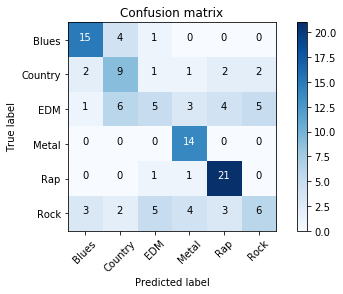

F1 micro: 0.578512396694
F1 macro: 0.559700786358


### Feature Classifier ###



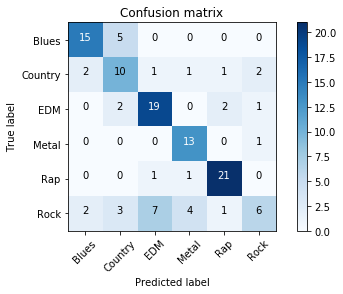

F1 micro: 0.694214876033
F1 macro: 0.677842615343


In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
print("### BOW Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_bow), ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])
print ("F1 micro: " + str(f1_score(pred_bow, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_bow, y_test, average='macro')))

print("\n\n### Feature Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_feature), ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])
print ("F1 micro: " + str(f1_score(pred_feature, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_feature, y_test, average='macro')))

Examine Mistakes in More Detail
---

In [44]:
for idx, genre in enumerate(y_test):
    if (genre != pred_feature[idx]):
        print ("\n###########################################################\n")
        print ("Song: "+titels_test[idx]+"\n")
        print ("Was "+genre+" Predicted "+pred_feature[idx] + "\n")
        #print ("confidence: ", pred_props[idx])
        print ("\n"+raw_lyrics_test[idx])
        


###########################################################

Song: Sassy

Was Rock Predicted EDM


We're rolling, you guys Why? Why? Why? Why? Why? Why? Why am I here? Why am I there? I don't care CARE! Oh, why I'm old Sit back down Sit back down Sit back down 'CAUSE I SAID SO! [Inger Lorre:] "You're so stupid I would have done anything for you Honey, your reputation is shit in this town You're so stupid I would have done anything for you Honey, your reputation is shit in this town" Oh, why? She's sassy She's walking tall 

###########################################################

Song: See See Baby

Was Blues Predicted Country


See-see baby See what you have done, Lordy mama No need to worry See-see baby See what you have done Yes, you've told me a lie Now you man have come That man you got, don't love you Yes, he told me so, Lordy mama No need to worry The man don't love you, yes he told me so He's just only jivin' you, baby He in love with the girl next do' Oh, an I love yo tea

Look At The Most Informative Words
---

In [45]:
def print_top10(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-100:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(vectorizer, cls,  ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])

Blues: nights rainin anytime girl looks ball tree bury stormy roll sox beer change bobby road walkin gulfport tears uumh treats bills detroit michigan lesson hearted babe slow jaw stuck ooh legged child shotgun town switch hmm vain drag station luck lee eve drunken natural automobile clothes dimples sittin people got little mood save oww fun pretty bourbon scotch drivin payin wimmen crawlin lovin starter lodi times lord early rooster whoo hooo short poor know sure mm ain spoon treat glamour cryin rain long mean crossroad man tell nough want christmas goin dog mornin gonna blues yes spoonful mmm woman baby
Country: hands kettle run sun today brought cradle shelter folks forgotten dew fool tells wind ramblers past corner started dixie talk wish comfort birmingham saddle freight new keeps proud sweetwater dear nah mem hair like haven aching shines played memory prison watching makes won em free care walked rock changes live comforts grass hardly ev booth arms expecting hurtin haunted line